# COGS 108 - Final Project

## Important

- ONE, and only one, member of your group should upload this notebook to TritonED. 
- Each member of the group will receive the same grade on this assignment. 
- Keep the file name the same: submit the file 'FinalProject.ipynb'.
- Only upload the .ipynb file to TED, do not upload any associted data. Make sure that for cells in which you want graders to see output that these cells have been executed.

## Group Members: Fill in the Student IDs of each group member here

Replace the lines below to list each persons full student ID, ucsd email and full name.

- A12785571, ekfu@ucsd.edu, Edwin Fu
- A12623303, jcloo@ucsd.edu, Joel Loo
- A13589612, bfbarry@ucsd.edu, Brian Barry
- A12690911, zes004@ucsd.edu, Sunny Sun
- A13736482, roz021@ucsd.edu, Roy Zhang
- A13014470, khh007@ucsd.edu, Kevin Huang


## Introduction: Background

From 2013-2018, the United States of America has gone through a period of time when there were over 260,000 reported occurrences of gun violence. With so many reported incidents within the span of only 5 years, there needs to be a way for citizens to find where all these incidents are occurring without having to sift through heaps of data. People should be aware of where areas of high gun violence incidents are occurring and how possible prevention can occur. We seek to find out whether or not gun violence incidents, household income level and rent level are correlated and if so, can there be a way to lower the gun violence rates in those areas such as certain counties or states. To operationalize this, we are using gun violence rates, household income levels and rent levels counts as our metrics since all three can be utilized for our research question of whether there is a correlation between rent, income and gun violence within an area of the United States.

To start with our analysis, we will start by importing some Python library packages for analyzing and graphing our data:

# Library imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

plotly.tools.set_credentials_file(username='jcloo', api_key='6Qa08K4DBMMNjPHL2p0T')


ModuleNotFoundError: No module named 'plotly'

In [10]:
# Configure Seaborn library
sns.set()
sns.set_context('talk')

In [11]:
#read datasets
url = "https://doc-0k-88-docs.googleusercontent.com/docs/securesc/a4oc2hqjnhqph43vaufe9fs3nelfc15u/n2em47vd7bqh0bu7a279knuoq26ugn8a/1552176000000/12632076152020903193/12632076152020903193/1KXzWFA-RIXwBXuOu81-E-MYi-e7WVfTj?e=download&nonce=1r1nehh1hfp4m&user=12632076152020903193&hash=uc1qcip4tede3ao389g85jg856941gf0"
gun_data = pd.read_csv("datasets/gun-violence-data_01-2013_03-2018.csv")
income_data = pd.read_csv("datasets/kaggle_income.csv", encoding = "ISO-8859-1")
rent_data = pd.read_csv("datasets/price.csv", encoding = "ISO-8859-1")
states = pd.read_csv("datasets/states.csv")
allcodes = pd.read_csv("datasets/fips-codes.csv")

city_metrics = pd.read_csv("datasets/updated_city_metrics.csv")
city_metrics_rent = pd.read_csv("datasets/updated_city_metrics_rent.csv")
county_data = pd.read_csv("datasets/county_incidents.csv")



In [12]:
#Remove null values
#gun_data.dropna(inplace = True)
#income_data.dropna(inplace = True)
gun_data_abbrev = gun_data[['state', 'city_or_county','n_killed', 'n_injured']]

KeyError: "['state' 'city_or_county' 'n_killed' 'n_injured'] not in index"

## Data Description

The datasets we are using are US State Population, Gun Violence, US Household Income. Details include state, county, state population, household income, its mean, its median, and its standard deviation, rent and state codes. We will be using these sets to find out if the frequency of gun violence has a direct correlation with household income with the effect of population density.
These datasets can be obtained on:

US State Population - https://www.kaggle.com/lucasvictor/us-state-populations-2018?fbclid=IwAR2QTVJfUDl20U0YXWy804-poFuxP1f5IDnJecWh0AMGgoJImjTS0DVNsos

Gun Violence - 
https://www.kaggle.com/jameslko/gun-violence-data

US Household Income -
https://www.kaggle.com/goldenoakresearch/us-household-income-stats-geo-locations

Rent
https://drive.google.com/a/ucsd.edu/file/d/1xidDkm2-oNx-RnI8lJxkmVBAW9JQnDea/view?usp=sharing

State Codes
https://drive.google.com/a/ucsd.edu/file/d/1Yyx3rBuoxZB8ENjJDFxJdFZ0I4ya3m8x/view?usp=sharing

# Data Cleaning/Pre-Processing
We used numerous datasets therefore we used different data cleaning analysis strategy in different cells. We first cleaned each dataset then we tried to merge the datasets into one for it to be easier to manipulate later to analyze the data.

# Data Visualization
Data are shown in visualized format via scatter plots and bubble maps

## Ethics/Privacy Considers
All information in the data set are sources in which are allowed free public access and for open source use. The rest of this report is all work done by our team. This report is not for commercial purposes. So, after careful examination, we strongly believe that our data does not have any privacy concerns.

In [3]:
#gun_data[(gun_data["city_or_county"]=="Mckeesport") & (gun_data["state"]=="Pennsylvania")]

## Clean/Merge Datasets By City

In [13]:
#CLEANING UP COUNTY DATAFRAME 
allcodes.drop_duplicates(subset=['COUNTYNAME', 'STATE'], inplace=True)


#### Below we match rows and merged by city in various datasets to organize our data. Then, we loop through the income data and agregated a datagram by city.

In [36]:
city_metrics = pd.DataFrame()
count = 0

for index, income_row in income_data.iterrows():
    city = income_row['City']
    state = income_row['State_Name']
    code = income_row['State_ab']
    county = income_row['County']
    lat = income_row['Lat']
    long = income_row['Lon']
    
    #print(city)
    #print(state)
    
    #get dataframe of incident rows with matching state and city
    incidents = gun_data_abbrev.loc[(gun_data['state']  == state) & (gun_data['city_or_county'] == city)]
    #print(incidents)
    #compute each city's total incidents and total deaths/ whatever metrics for violence we want to use
    num_incidents = incidents.shape[0]
    total_killed = incidents['n_killed'].sum()
    total_injured = incidents['n_injured'].sum()

    #extract income metrics for city
    mean_inc = income_row['Mean']
    median_inc = income_row['Median']
    stdev_inc = income_row['Stdev']
    
    #construct row of the values we want to describe the city
    city_row = pd.DataFrame(columns = ['state','city', 'county', 'code','mean_inc','median_inc','stdev_inc','num_incidents','total_killed','total_injured', 'lat', 'long'])
    city_row.loc[0] = [state,city,county,code,mean_inc,median_inc,stdev_inc,num_incidents,total_killed,total_injured, lat, long]
    #print(city_row)
    
    city_metrics = city_metrics.append(city_row)

In [37]:
city_metrics.head()

,state,city,county,code,mean_inc,median_inc,stdev_inc,num_incidents,total_killed,total_injured,lat,long
0,Alabama,Chickasaw,Mobile County,AL,38773,30506,33101,1,0,0,30.771450,-88.079697
0,Alabama,Louisville,Barbour County,AL,37725,19528,43789,2,0,3,31.708516,-85.611039
0,Alabama,Columbiana,Shelby County,AL,54606,31930,57348,4,0,5,33.191452,-86.615618
0,Alabama,Satsuma,Mobile County,AL,63919,52814,47707,0,0,0,30.874343,-88.009442
0,Alabama,Dauphin Island,Mobile County,AL,77948,67225,54270,0,0,0,30.250913,-88.171268


In [50]:
#subset rent data to take only large city (avoid duplicates)

city_metrics_rent = pd.DataFrame()
count = 0

for index, rent_row in rent_data.iterrows():
    city = rent_row['City']
    state_abbrev = rent_row['State']
    
    #convert to full state name by comparing to states list
    state = states.loc[states['Abbreviation'] == state_abbrev]['State'].values[0]
    
#    print(city)
#    print(state)
    
    #get dataframe of incident rows with matching state and city
    incidents = gun_data_abbrev.loc[(gun_data_abbrev['state']  == state) & (gun_data_abbrev['city_or_county'] == city)]
    the_county = city_metrics.loc[(city_metrics['state'] == state) & (city_metrics['city'] == city)]
    #print(the_county)
    #compute each city's total incidents and total deaths/ whatever metrics for violence we want to use
    num_incidents = incidents.shape[0]
    total_killed = incidents['n_killed'].sum()
    total_injured = incidents['n_injured'].sum()
    


    #extract rent metrics for city
    latest_rent = rent_row['January 2017']
    
    #extract county for city
    if the_county.empty != True:
        #print(the_county)
        county_list = the_county.at[0,'county']
        #print(the_county)
        #print(the_county.at[0, 'county'])
        #print(the_county.at[0, 'county'])
        #print("length of most counties is ", len(county_list))
        #print("most of the counties are ", county_list)
        if type(county_list) == str:
            county = county_list
        else:
            county = county_list[0]
        #if len(county) == 1:
            #print(type(county_list))
            #print("size of list is ", len(county_list))
            #print("county list is ", county_list)
            #print(county)

    #construct row of the values we want to describe the city
    city_row = pd.DataFrame(columns = ['state','code','city', 'county','latest_rent','num_incidents','total_killed','total_injured'])
    city_row.loc[0] = [state, state_abbrev,city,county,latest_rent,num_incidents,total_killed,total_injured]
    city_metrics_rent = city_metrics_rent.append(city_row)

In [89]:
#city_metrics_rent.head()
#city_metrics_rent.to_csv('updated_city_metrics_rent.csv', index = None, header=True)

In [86]:

county_data = pd.DataFrame()

#county_fips['state code'] = county_fips['state code'].apply(lambda x: str(x).zfill(2))
#county_fips['county code'] = county_fips['county code'].apply(lambda x: str(x).zfill(3))
#county_fips['FIPS'] = county_fips['state code'] + county_fips['county code']




for index, FIPS_row in allcodes.iterrows():
    county = FIPS_row['COUNTYNAME']
    code = FIPS_row['STCOUNTYFP']
    state = FIPS_row['STATE']
    
    all_counties = city_metrics_rent.loc[(city_metrics_rent['county'] == county) & (city_metrics_rent['code'] == state)]
    #print(all_counties)
    num_incidents = all_counties['num_incidents'].sum()
    
    to_add = pd.DataFrame(columns = ['county', 'state', 'fips', 'num_incidents'])
    to_add.loc[0] = [county, state, code, num_incidents]
    county_data = county_data.append(to_add)
    

    

In [88]:

#county_data.to_csv('county_incidents.csv', index = None, header=True)

## Data Visualization

In [31]:
city_metrics['mean_inc'] = pd.to_numeric(city_metrics['mean_inc'])
city_metrics['num_incidents'] = pd.to_numeric(city_metrics['num_incidents'])
city_metrics_rent['latest_rent'] = pd.to_numeric(city_metrics_rent['latest_rent'])
city_metrics_rent['num_incidents'] = pd.to_numeric(city_metrics_rent['num_incidents'])

In [32]:
city_metrics.dtypes

state             object
city              object
county            object
code              object
mean_inc           int64
median_inc         int64
stdev_inc          int64
num_incidents      int64
total_killed       int64
total_injured      int64
lat              float64
long             float64
dtype: object

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


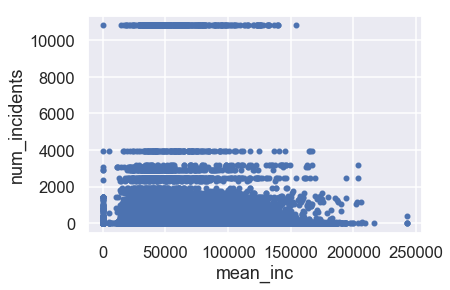

In [33]:
city_metrics.plot.scatter(x = 'mean_inc', y = 'num_incidents')

#inc_incidents_scat =  sns.lmplot(x ="mean_inc", y ="num_incidents", data =city_metrics, aspect = 1.5)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


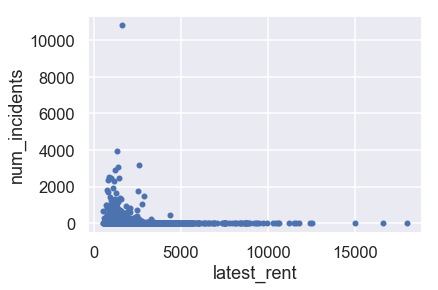

In [34]:

city_metrics_rent.plot.scatter(x = 'latest_rent', y = 'num_incidents')

In [35]:
#county_data.loc[(county_data['county'] == 'Cook County')]
#county_data.sort_values(by='num_incidents')
#city_metrics_rent.sort_values(by='num_incidents')

#### Below we created a data visualization of our data via a heatmap of the United States using plotly

In [36]:
colorscale = ["#f8f9f2", "#f4f9e4", "#e0f4c3", "#bdf2a0", "#6ed85b", "#53ad3d", "#4b8706",
    "#ffef7d", "#f7e861", "#f9e603", "#eeb753", "#f3ac1f", "#db913a", "#e06338",
    "#e55217", "#d93434", "#b50000"
]
endpts = list(np.linspace(1, 9000, len(colorscale) - 1))
fips = county_data['fips'].tolist()
#values = df_sample['Unemployment Rate (%)'].tolist()
values = county_data['num_incidents'].tolist()

fig = ff.create_choropleth(
    fips = fips, values = values, scope = ['usa'],
    binning_endpoints = endpts, colorscale = colorscale,
    show_state_data = False,
    show_hover = True, centroid_marker = {
        'opacity': 0
    },
    asp = 2.9,
    title = 'USA Crime Incidents' ,
    legend_title = '# of incidents'
)
py.iplot(fig, filename = 'choropleth_full_usa')


C:\Users\j2loo\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:248: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

C:\Users\j2loo\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:248: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some sugge

The draw time for this plot will be slow for clients without much RAM.


C:\Users\j2loo\Anaconda3\lib\site-packages\plotly\api\v1\clientresp.py:40: UserWarning:

Estimated Draw Time Slow

C:\Users\j2loo\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



#### Below we created data visualizaton of our data by creating a bubble map for the number of gun violence incidents, color based on mean income in that region.

In [ ]:
#Code provided from the Plotly API, https://plot.ly/python/bubble-maps/

#what shows up when you click on a bubble
city_metrics['text'] = city_metrics['county'] + '<br>Mean Income: $' + (city_metrics['mean_inc']).astype(str) + ''
#legend ranges of mean income
limits = [(0,10000),(10001,20000),(20001,30000),(30001,60000),(60001,90000),(90001,120000),(120001,180000),(180001,240000),(240001,245000)]
#color ranges for legend
colors = ["rgb(181,0,0)","rgb(217,52,52)","rgb(229,82,23)","rgb(224,99,56)","rgb(243,172,31)","rgb(249,230,3)","rgb(255,239,125)","rgb(83,173,61)", "rgb(224,244,195)"]

cities = []
scale = 20

#sets up markers for each range
for i in range(len(limits)):
    lim = limits[i]
    df_sub = city_metrics[lim[0]:lim[1]]
    city = go.Scattergeo(
        locationmode = 'USA-states',
        lon = city_metrics['long'],
        lat = city_metrics['lat'],
        text = df_sub['text'],
        marker = go.scattergeo.Marker(
            size = df_sub['num_incidents'] / scale,
            color = colors[i],
            line = go.scattergeo.marker.Line(
                width=0.5, color='rgb(40,40,40)'
            ),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    cities.append(city)

#sets up layout for the bubble map
layout = go.Layout(
        title = go.layout.Title(
            text = '2013-2018 US Number of Gun Violence Incidents<br>(Click legend of mean incomes to toggle traces)'
        ),
        showlegend = True,
        geo = go.layout.Geo(
            scope = 'usa',
            projection = go.layout.geo.Projection(
                type='albers usa'
            ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        )
    )

#displays bubble map
fig = go.Figure(data=cities, layout=layout)
py.iplot(fig, filename='d3-bubble-map-populations')

In [ ]:
city_metrics.columns

# Correlation Analysis
Below we extract numeric data from city metrics and cast the data into integers.

In [ ]:
income_vs_incidents = city_metrics[['mean_inc', 'median_inc', 'stdev_inc', 'num_incidents', 'total_killed', 'total_injured']]
income_vs_incidents = income_vs_incidents.astype('int64')
income_vs_incidents.head()

In [ ]:
#compute correlation matrix
income_vs_incidents_corrs = income_vs_incidents.corr()
income_vs_incidents_corrs

In [ ]:
city_metrics_rent.columns

In [ ]:
rent_vs_incidents = city_metrics_rent[['latest_rent','num_incidents','total_killed','total_injured']]
rent_vs_incidents.head()


In [ ]:
rent_vs_incidents_corrs = rent_vs_incidents.corr()
rent_vs_incidents_corrs

## Data Analysis & Results:
We find that there isn’t a correlation between income & rent compared to number of gun violence incidents. This (dis)proves our hypothesis as there is no correlation between income or rent when comparing them to the number of gun violence incidents. However, there is a potential correlation between latest rent to the number of incidents which can give an insight that the lower the rent, the higher the number of incidents occurred as we see more points grouped together in the lower rent level spectrum.

## Conclusion and Discussion
From the correlation analysis, there is not a significant amount to see a correlation between income & number of incidents. The scatter plots were based off of lower income & rent to the number gun incidents. With the lower income to number gun incidents scatter plot, we see that there is no correlation but with lower rent to the number of gun incidents scatter plot, we see a potential correlation with the lower the rent, the higher the number of incidents occurred. In conclusion, there are a lot of factors to consider when it comes to crime and cannot be based solely off of income.